In [1]:
import os

os.environ["GEOMSTATS_BACKEND"] = "pytorch"


import geomstats.backend as gs
import matplotlib.pyplot as plt
import torch

import neural_metric
from geomstats.geometry.special_orthogonal import SpecialOrthogonal
import numpy as np
import torch.nn.functional as F
import main_eval 
import default_config

INFO: Using pytorch backend


# Evaluate Synthetic Data

### From analytic form of immersion

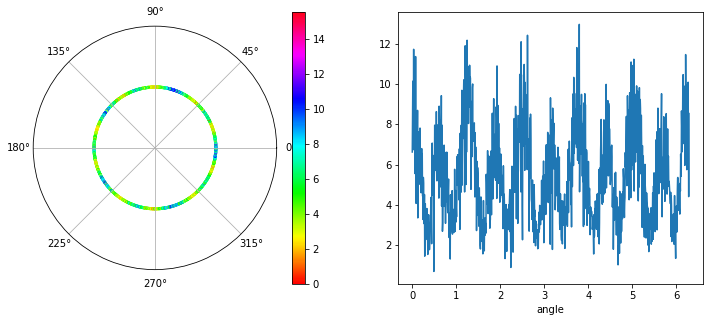

In [2]:
params = {
    "immersion_type": "analytic",
    "radius": 1,
    "n_wiggles": 5,
    "amp_wiggles": 0.3,
    "embedding_dim": 5,
    "model_filename": None,
}

angles = gs.linspace(0,2*gs.pi,1000)

mean_curv_vectors = main_eval.mean_curv_vector(angles,params)

mean_curv_norm = [gs.linalg.norm(vec) for vec in mean_curv_vectors]

main_eval.plot(angles,mean_curv_norm)

### From learned immersion via VAE

In [3]:
results_prefix = ""

model_filename = "/home/facosta/code/abn/abn/results/trained_models/wiggles_2022-08-26 01:41:00_model.pt"

#model_filename = f"results/trained_models/{results_prefix}_model.pt"

params = {
    "immersion_type": "VAE",
    "radius": None,
    "n_wiggles": None,
    "amp_wiggles": None,
    "embedding_dim": default_config.embedding_dim,
    "model_filename": model_filename,
}

angles = gs.linspace(0,2*gs.pi,100)

mean_curv_vectors = main_eval.mean_curv_vector(angles,params)

mean_curv_norm = [gs.linalg.norm(vec) for vec in mean_curv_vectors]

main_eval.plot(angles,mean_curv_norm)

TypeError: zeros(): argument 'size' (position 1) must be tuple of ints, not NoneType